In [474]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf


In [524]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [541]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, stratify=y_train_full, test_size=0.1, random_state=2)

In [477]:
print("Size and shape of X_train: {}\nSize and shape of y_train: {}".format(X_train.shape, y_train.shape))
print("\n")
print("Size and shape of X_valid: {}\nSize and shape of y_valid: {}".format(X_valid.shape, y_valid.shape))
print("\n")
print("Size and shape of X_test: {}\nSize and shape of y_test: {}".format(X_test.shape, y_test.shape))


Size and shape of X_train: (54000, 28, 28)
Size and shape of y_train: (54000,)


Size and shape of X_valid: (6000, 28, 28)
Size and shape of y_valid: (6000,)


Size and shape of X_test: (10000, 28, 28)
Size and shape of y_test: (10000,)


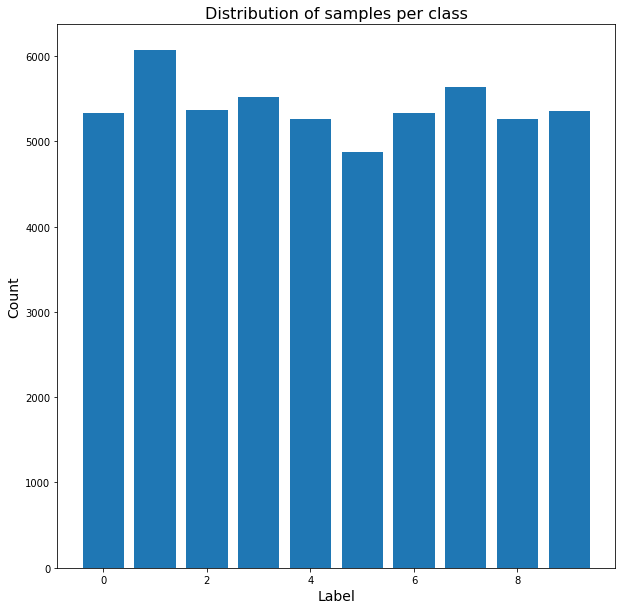

In [478]:
labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 10))
plt.bar(labels, counts)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Label", fontsize=14)
plt.title("Distribution of samples per class", fontsize=16)
plt.show()

In [479]:
print("Missing values? {}".format(np.isnan(np.min(X_train))))
print("Missing values? {}".format(np.isnan(np.min(y_train))))

Missing values? False
Missing values? False


#### Normalization

In [542]:
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

#### One hot encoding

In [551]:
y_train = to_categorical(y_train, num_classes=10)   
y_valid = to_categorical(y_valid, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#### Plot example data

In [482]:
def plot_mnist(images, height=28, width=28, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.05)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.binary)
        plt.axis(False)

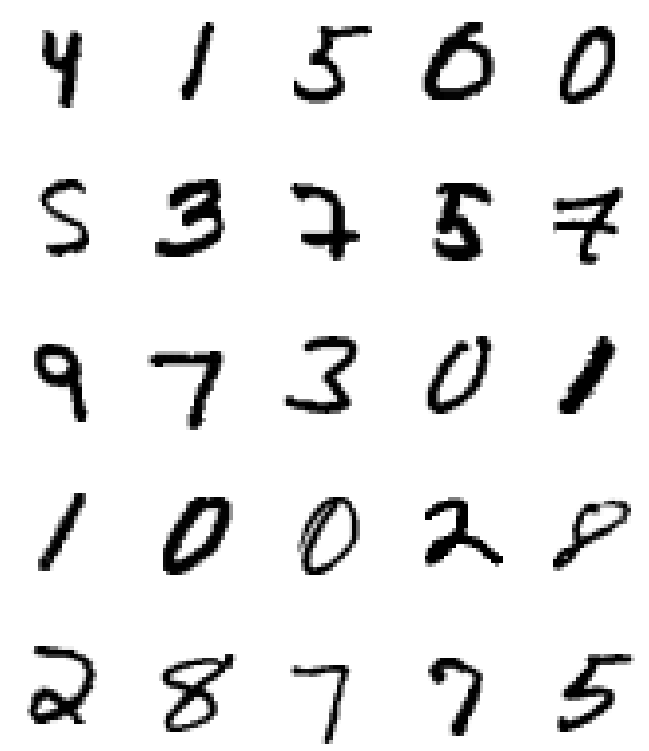

In [483]:
example_images = X_train[:25]
plot_mnist(example_images, n_row=5, n_col=5)


#### Defining the model

In [484]:
model = Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', 
                        activation='elu', input_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same',
                        activation='elu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                        activation='elu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                        activation='elu'),
    keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [485]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  

#### Data Augmentation

In [486]:
# Expanding dimensions 
X_train = np.expand_dims(X_train, 3)
X_valid = np.expand_dims(X_valid, 3)
X_test = np.expand_dims(X_test, 3)

In [487]:
data_generation = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

data_generation.fit(X_train)

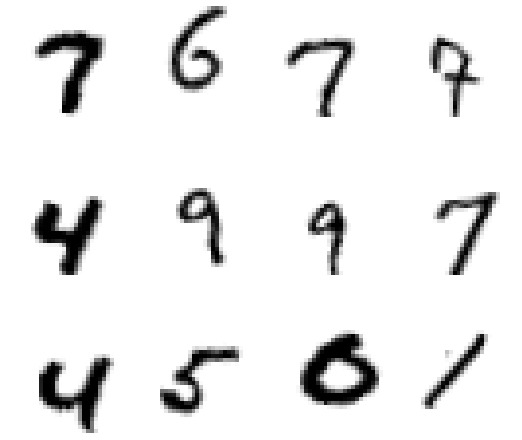

In [488]:
def plot_augmented_mnist(X_train=X_train, y_train=y_train, height=28, width=28, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.05)
    for X_batch, _ in data_generation.flow(X_train, y_train, batch_size=n_row*n_col):   
        for i in range(n_row * n_col):
                plt.subplot(n_row, n_col, i + 1)
                plt.imshow(X_batch[i].reshape((height, width, 1)), cmap=plt.cm.binary)
                plt.axis(False)
        break

plot_augmented_mnist()

In [489]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
epochs=50
batch_size=86   # try 32 batch_size 

history = model.fit(data_generation.flow(X_train, y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(X_valid, y_valid),
                              verbose=2, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/30
627/627 - 118s - loss: 0.3451 - accuracy: 0.8905 - val_loss: 0.0580 - val_accuracy: 0.9812 - lr: 0.0010 - 118s/epoch - 188ms/step
Epoch 2/30
627/627 - 118s - loss: 0.1117 - accuracy: 0.9669 - val_loss: 0.0360 - val_accuracy: 0.9893 - lr: 0.0010 - 118s/epoch - 188ms/step
Epoch 3/30
627/627 - 120s - loss: 0.0840 - accuracy: 0.9756 - val_loss: 0.0278 - val_accuracy: 0.9913 - lr: 0.0010 - 120s/epoch - 191ms/step
Epoch 4/30
627/627 - 116s - loss: 0.0748 - accuracy: 0.9781 - val_loss: 0.0271 - val_accuracy: 0.9907 - lr: 0.0010 - 116s/epoch - 185ms/step
Epoch 5/30
627/627 - 120s - loss: 0.0691 - accuracy: 0.9799 - val_loss: 0.0325 - val_accuracy: 0.9897 - lr: 0.0010 - 120s/epoch - 191ms/step
Epoch 6/30
627/627 - 109s - loss: 0.0649 - accuracy: 0.9817 - val_loss: 0.0267 - val_accuracy: 0.9932 - lr: 0.0010 - 109s/epoch - 175ms/step
Epoch 7/30
627/627 - 107s - loss: 0.0650 - accuracy: 0.9810 - val_loss: 0.0291 - val_accuracy: 0.9912 - lr: 0.0010 - 107s/epoch - 171ms/step
Epoch 8/30
62

In [491]:
# model.save("mnist30ep.h5")

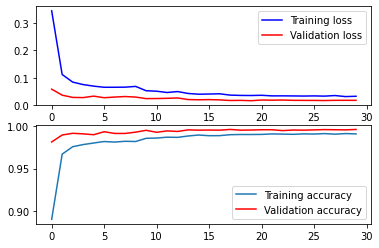

In [490]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(history.history['loss'], color='b', label='Training loss')
axes[0].plot(history.history['val_loss'], color='r', label='Validation loss', axes=axes[0])
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Training accuracy')
axes[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axes[1].legend()

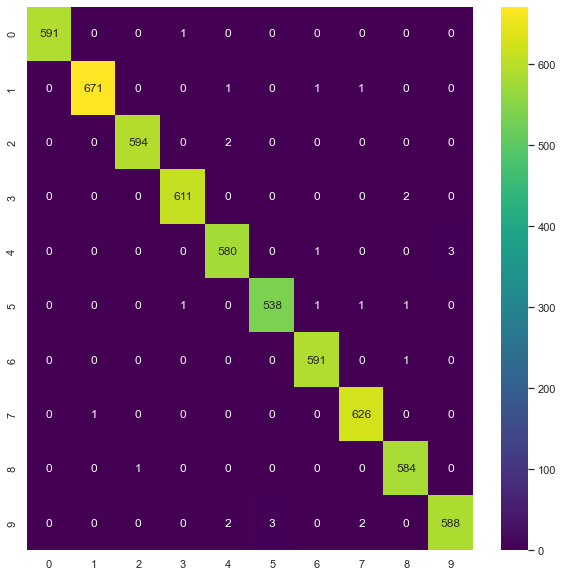

In [549]:
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 10))
sns.set(style='white', context='notebook', palette='deep')
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='g')
plt.show()

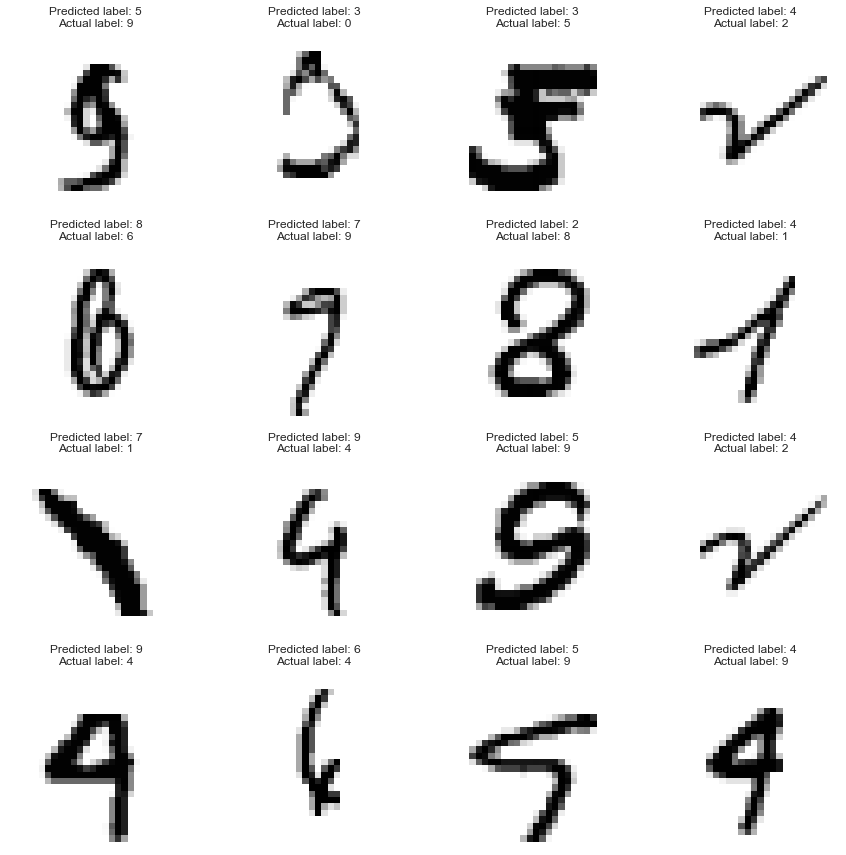

In [522]:
errors = (y_pred_classes != y_true)
y_pred_cls_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_valid_errors = X_valid[errors]

def show_errors(idx, image, prediction, true_label, rows=4, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    cnt = 0
    for row in range(rows):
        for col in range(cols):
            error = idx[cnt]
            axes[row, col].imshow((image[error]).reshape((28, 28)), cmap='binary')
            axes[row, col].set_title("Predicted label: {}\nActual label: {}".format(prediction[error], true_label[error]))
            axes[row, col].axis('off')
            cnt += 1

rows = 4
cols = 4
y_pred_errors_probability = np.max(y_pred_errors, axis=1)
true_probability_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))
pred_true = np.argsort(y_pred_errors_probability - true_probability_errors)
most_important_errors = pred_true[-rows*cols:]
show_errors(most_important_errors, X_valid_errors, y_pred_cls_errors, y_true_errors)

In [550]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
acc = accuracy_score(y_true, y_pred_classes)
print("Accuracy on the test set: {}".format(acc))

Accuracy on the test set: 0.996
